In [1]:
# import modules
#%matplotlib inline
import os
#from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
import xarray as xr
#from scipy.fft import fft, ifft, fftfreq
#from scipy import signal
#from mpi4py import MPI
import h5py
from scipy.optimize import curve_fit
plt.style.use('default')
#plt.rcParams['text.usetex'] = False
from scipy.special import hyp2f1
import re
# from mpmath import lerchphi
from tabulate import tabulate

In [2]:
#%%file function_definitions.py

# import numpy as np
# import matplotlib.pyplot as plt
# import xarray as xr
# from scipy.fft import fft
# function definitions

#This function is modified to return Xarray instead of Dictionary. 
def read_cbd(file_path):
    '''
    read_cbd: reads the cbd file data
    Arguments:
    file_path-- path where the file is located
    Return--
    xr_data-- data_matrix: 3-D matrix of size (N_x, N_y, N_z)
          x-coord: 1-D array of  x-coordinates size (N_x,1)
          y-coord: 1-D array of  y-coordinates size (N_y,1)
          z-coord: 1-D array of  z-coordinates size (N_z,1)
    '''
    f = open(file_path, "rb")
    id = np.fromfile(f, dtype=np.int64, count=1)[0]
    if id == 288230376151834571:
        T = np.float32
    elif id == 576460752303546315:
        T = np.float64
    else:
        raise ValueError("Invalid ID")
    N = tuple(np.fromfile(f, dtype=np.int64, count=3))
    xmin = tuple(np.fromfile(f, dtype=np.float64, count=3))
    xmax = tuple(np.fromfile(f, dtype=np.float64, count=3))
    x1, x2, x3 = (np.fromfile(f, dtype=np.float64, count=n) for n in N)
    data1 = np.fromfile(f, dtype=T, count=np.prod(N)).reshape(N, order="F")
    #dic = {"data":data1, "x-coord":x1, "y-coord":x2, "z-coord":x3, "diagonal_points":[xmin,xmax]}
    xr_data = xr.DataArray(
        data1,
        dims = ("x", "y", "z"),
        coords = { "x" : x1,
                  "y" : x2,
                  "z" : x3
        }   
    )
    f.close()
    return xr_data

def h5_in_xarray(field):
    #hf = h5py.File(filepath, 'r')
    data = hf.get('%s' % field)
    x1 = hf.get('x-coord')
    x2 = hf.get('y-coord')
    x3 = hf.get('z-coord')
    xr_data = xr.DataArray(
        np.array(data),
        dims = ("x", "y", "z"),
        coords = { "x" : np.array(x1),
                  "y" : np.array(x2),
                  "z" : np.array(x3)
        }   
    )
    
    return xr_data

def create_xarray(u):
    
    # This function creates an xarray that has same data size and coordinates aligned with the input xarray u
    new_array = xr.DataArray(
        np.empty(u.shape),
        dims = ("x", "y", "z"),
        coords = { "x" : u['x'],
              "y" : u['y'],
              "z" : u['z']
        }
    )
    
    return new_array

def intp_w_to_uvp(w, u):
    
    # This function interpolates w to uvp nodes
    w_intp = create_xarray(u)
    w_intp[:, :, :-1] = w.interp(z = u['z'][:-1])
    w_intp[:, :, u['z'].size - 1] = 0
    
    return w_intp

def u_log(z, d, z0):
        return (0.45 / 0.4) * np.log((z - d) / z0)
    
def compute_stresses(prefix, suffix_list, field_list, filepath):
    f = {}  # A dictionary to hold all the variables
    
    i = 0
    for suffix in suffix_list:
        for field in field_list:

            fp = "%s/%s_%s%s.h5" % (filepath, prefix, field, suffix) 
            f["%s%d" % (field, i)] = h5_in_xarray(fp)

        i += 1
    del i
    
    dc = {}  # A dictionary to store dispersive covariances
    rs = {}  # A dictionary to store Reynolds stresses
    sub = {} # A dictionaty to store subgrid stresses
    stress = {} # To store total stresses
    
    for j in range(len(suffix_list)):
        dc["uw%d" % (j)] = (f["u%d" % (j)]*f["w%d" % (j)]).mean(dim = ['x', 'y']) - f["u%d" % (j)].mean(dim = ['x', 'y']) * f["w%d" % (j)].mean(dim = ['x', 'y'])
        rs["uw%d" % (j)] = f["uw%d" % (j)].mean(dim = ['x', 'y']) - (f["u%d" % (j)] * f["w%d" % (j)]).mean(dim = ['x', 'y'])

    i = 0
    for suffix in suffix_list:
        fp = "%s/%s_txz%s.h5" % (filepath, prefix, suffix) 
        sub["uw%d" % (i)] = h5_in_xarray(fp)
        sub["uw%d" % (i)] = intp_w_to_uvp(sub["uw%d" % (i)], f["u%d" % (i)]).mean(dim = ['x', 'y'])
        i += 1
    del i
    
    # Calculating the totla stress
    for j in range(len(suffix_list)):
        stress["uw_%d" % (j)] = dc["uw%d" % (j)] + rs["uw%d" % (j)] + sub["uw%d" % (j)]
        
    return f, dc, rs, sub, stress

def output_keylist(f, con1, con2):
    '''
    Arguments--
    f - the dictionary containing all the data
    con1 - what contains in the list (often the packing density)
    con2 - a "startswith condition"
    '''
    key_list = list(f.keys())
    key_list = [match for match in key_list if con1 in match and match.startswith(con2)]
    key_list.sort()
    key_list = key_list[3:] + key_list[0:3]
    if con1 == "l2" or con1 == "l6":
        key_list = key_list[3:4] + key_list[0:3] + key_list[4:]
    
    return key_list

def plot_firstorder(pack_den):
    fig1 = plt.figure()
    key_list = output_keylist(f, pack_den, "u_")
    ax1 = fig1.add_subplot(111)
    number_of_plots = len(key_list)
    colormap = plt.cm.rainbow #I suggest to use nipy_spectral, Set1,Paired
    ax1.set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1,number_of_plots)])

    for key in key_list:
        ax1.plot((f["%s" % key]).mean(dim = ['x', 'y']), f["%s" % key]['z'], label='%s' % key)
    ax1.legend()
    ax1.set_title("streamwise velocity")
    ax1.set_xlabel("u")
    ax1.set_ylabel("z")
    fig1.savefig("u_%s.png" % pack_den, dpi=500)
    
def plot_secondorder(pack_den, var):
    fig1 = plt.figure()
    key_list = output_keylist(f, pack_den, "%s_" % var)
    ax1 = fig1.add_subplot(111)
    number_of_plots = len(key_list)
    colormap = plt.cm.rainbow #I suggest to use nipy_spectral, Set1,Paired
    ax1.set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1,number_of_plots)])

    for key in key_list:
        ax1.plot(stress["%s" % key], stress["%s" % key]['z'], label='%s' % key)
    ax1.legend()
    ax1.set_title("%s variance - %s packing density" % (var, pack_den))
    ax1.set_xlabel("%s" % var)
    ax1.set_ylabel("z")
    fig1.savefig("%s_%s.png" % (var, pack_den), dpi=500)

In [3]:
# Let's load the entire data
field_list = ['u', 'v', 'w', 'uu', 'uw']
f = {} # Loads all the variables
#h5_files = ['chan_l4_8x24x48.h5']
h5_files = os.listdir('/home/as2204/TACC_postprocess/high_reso_new_stl_averages')
h5_files = [match for match in h5_files if "ruw" not in match]
filepath = '/home/as2204/TACC_postprocess/high_reso_new_stl_averages'

for sim in h5_files:
    # print(sim)
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

In [4]:
sim = 'chan_hxsx83e-3_8x36x48.h5'
    # print(sim)
hf = h5py.File('%s/%s' % (filepath, sim), 'r')
for field in field_list:
    f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

In [5]:
sim = 'chan_hxsx83e-3_4x18x24.h5'
    # print(sim)
hf = h5py.File('%s/%s' % (filepath, sim), 'r')
for field in field_list:
    f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

### Figure 13

Text(0.06, 0.6, '$\\frac{(x_3 - d)}{L_3}$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


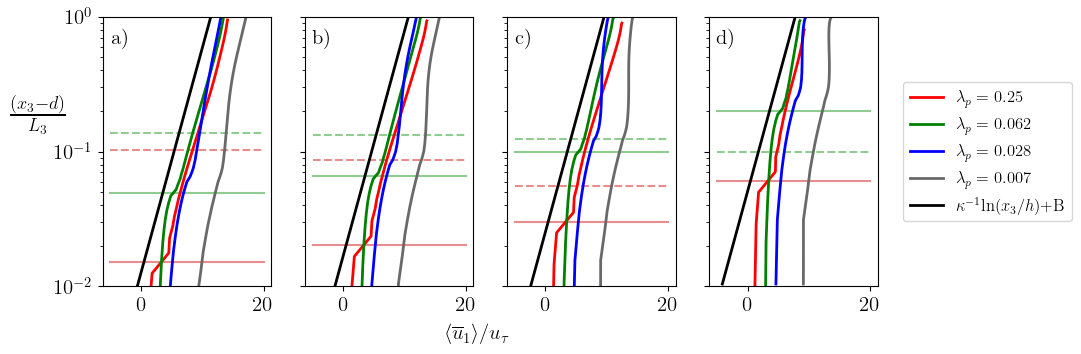

In [6]:
# Getting all the four domain heights in one plot of 4 subplots like the paper template
import cubehelix
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)

fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)

pack_list = ["l2", "l4", "l6", "l12"]
den_list = [0.25, 0.062, 0.028, 0.007]
domh = ["16", "12", "8", "4"]

d_list2 = [0.75837542125692, 0.20448135561821737, 0, 0]
z0_list2 = [0.06649667492688939, 0.0854966106356029, 0.05056926143920569, 0.009022629531375207]
for index, delta in enumerate(domh):
    delta = int(delta)  
    key_list = []
    for pack_den in pack_list:
        key_list.append(f'u_{pack_den}_{delta}x{delta*3}x{delta*6}')

    
    z_reso = 12
    kappa = 0.384 # Values from Monkewitz paper
    B = 4.17  # These are the values from Monkewitz
    node1 = int(0 * z_reso)
    node2 = int(delta * z_reso)
    
    # print(key_list)
    # ax1 = fig1.add_subplot(111)
    # number_of_plots = 5
    # # colormap = cubehelix.cmap(startHue=240,endHue=-300,minSat=1,maxSat=2.5,minLight=.3,maxLight=.8,gamma=.9)
    # colormap = cubehelix.cmap(start=0.5 , rotation=-1.0, hue=1, gamma=1.0)  # works well with number of plots 5
    # # colormap = plt.cm.cubehelix #I suggest to use nipy_spectral, Set1,Paired
    # axs[index].set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1,number_of_plots)])
    namelist = ['a)', 'b)', 'c)', 'd)']
    clist = ['r', 'g', 'b', 'dimgrey']
    alfa = 0.53
    axs[index].semilogy(np.linspace(-5, 20, 50), (np.ones(50) - d_list2[0])/delta, color='tab:red', alpha = alfa)
    axs[index].semilogy(np.linspace(-5, 20, 50), (np.ones(50) - d_list2[1])/delta, color='tab:green', alpha = alfa)
    axs[index].semilogy(np.linspace(-5, 20, 50), 0.15 * np.ones(50) - d_list2[0]/delta, color='tab:red', linestyle='dashed', alpha = alfa) #, label='Log law bound')
    axs[index].semilogy(np.linspace(-5, 20, 50), 0.15 * np.ones(50) - d_list2[1]/delta, color='tab:green', linestyle='dashed', alpha = alfa)
    for index1, key in enumerate(key_list):
        # match = pattern.findall(key)
        # delta = int(match[1])
        # ly = int(match[2])
        col = clist[index1]
        if index == 3:
            axs[index].semilogy((f[key]).mean(dim = ['x', 'y'])[node1:node2], (f[key]['z'][node1:node2] - d_list2[index1])/delta, color=col, linewidth=2, label=f'$\lambda_p = {den_list[index1]}$')
        else:
            axs[index].semilogy((f[key]).mean(dim = ['x', 'y'])[node1:node2], (f[key]['z'][node1:node2] - d_list2[index1])/delta, color=col, linewidth=2, label=f'{pack_den}')
    plt.text(0.1, 0.9, namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0.01, 1)
    # axs[index].semilogy(np.linspace(-5, 20, 50), np.ones(50)/delta, color='tab:cyan') #, label='Canopy height')
    
    axs[index].semilogy(np.log(f[key]['z'][node1:node2].values)/kappa + B, f[key]['z'][node1:node2] / delta, 'k', linewidth=2, label=r'$\kappa^{-1}$' + 'ln' + r'$(x_3/h) + $' + 'B')
axs[3].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)
fig1.text(0.5, -0.025, r'$\langle\overline{u}_1\rangle/u_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.06, 0.6, r'$\frac{(x_3 - d)}{L_3}$', ha='center', va='center', rotation='horizontal', fontsize=19)
# plt.tight_layout()
# fig1.savefig('eps_figs/log_law_existence_hscaling.pdf', format='pdf', bbox_inches="tight")

### Figure 8

['u_l2_4x12x24', 'u_l2_8x24x48', 'u_l2_12x36x72', 'u_l2_16x48x96']
['u_l4_4x12x24', 'u_l4_8x24x48', 'u_l4_12x36x72', 'u_l4_16x48x96']
['u_l6_4x12x24', 'u_l6_8x24x48', 'u_l6_12x36x72', 'u_l6_16x48x96']
['u_l12_4x12x24', 'u_l12_8x24x48', 'u_l12_12x36x72', 'u_l12_16x48x96']


Text(0.08, 0.5, '$x_3/h$')

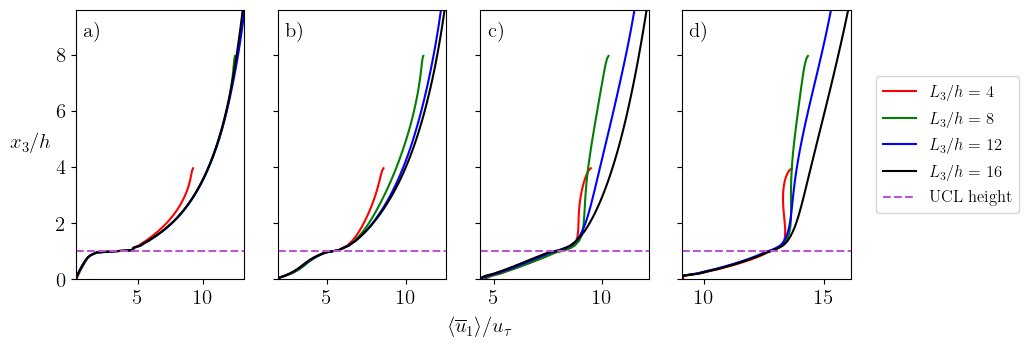

In [7]:
import cubehelix
from matplotlib import rc
import matplotlib
plt.style.use('default')
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)

fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
pattern = re.compile(r'\d+')
pack_list = ["l2", "l4", "l6", "l12"]
for index, pack_den in enumerate(pack_list):   
    # key_list = list(f.keys())
    # key_list = [match for match in key_list if match.startswith("u_") and pack_den in match]
    key_list = [f'u_{pack_den}_4x12x24', f'u_{pack_den}_8x24x48', f'u_{pack_den}_12x36x72', f'u_{pack_den}_16x48x96']
    # key_list = [match for match in key_list if "_4x12" in match or "_8x36" in match or "_16x72" in match or "l4_4x24" in match or "l12_4x24" in match or "_12x" in match]
    # key_list.sort()
    # key_list = key_list[2:] + key_list[:2]
    print(key_list)

    namelist = ['a)', 'b)', 'c)', 'd)']
    clist = ['r', 'g', 'b', 'k']
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[1])
        ly = int(match[2])
        if index == 3:
            axs[index].plot((f["%s" % key]).mean(dim = ['x', 'y'])[:120], f["%s" % key]['z'][:120], clist[index1], linewidth=1.5, label=r'$L_3/h = %d$' % int(delta))
        else:
            axs[index].plot((f["%s" % key]).mean(dim = ['x', 'y'])[:120], f["%s" % key]['z'][:120], clist[index1], linewidth=1.5)
    plt.text(0.1, 0.9, namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 9.6)
    axs[index].set_xlim((f["%s" % key]).mean(dim = ['x', 'y'])[0].values, (f["%s" % key]).mean(dim = ['x', 'y'])[120].values)
    axs[index].plot(np.linspace((f["%s" % key]).mean(dim = ['x', 'y'])[0].values, (f["%s" % key]).mean(dim = ['x', 'y'])[120].values, 20), np.ones(20), color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
axs[3].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)
fig1.text(0.53, -0.025, r'$\langle\overline{u}_1\rangle/u_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.08, 0.5, r'$x_3/h$', ha='center', va='center', rotation='horizontal', fontsize=15)
# plt.tight_layout()
# fig1.savefig('eps_figs/vel_domhimpact_limupdated.pdf', format='pdf', bbox_inches="tight")

### Figure 11

In [8]:
def output_d_kanda2(pack_den):
    "highest values"
    if pack_den == "500":
        return 0.77
    if pack_den == "250":
        return 0.4
    if pack_den == "167":
        return 0.06
    if pack_den == "83":
        return 0


def project_to_delta16(ddelta, d16):
    n = d16.size
    z_grid = np.linspace(ddelta['z'][0], ddelta['z'][-1], n)
    vel_intp = ddelta.interp(z = z_grid)
    return vel_intp

def plot_firstorder_outer_defect(pack_den, ax1, clist, namelist, index):
    # fig1 = plt.figure()
    key_list = [f'u_hxsx{pack_den}e-3_4x12x24', f'u_hxsx{pack_den}e-3_8x24x48', f'u_hxsx{pack_den}e-3_12x36x72', f'u_hxsx{pack_den}e-3_16x48x96']

    if pack_den == '83':
        key_list = [f'u_hxsx{pack_den}e-3_4x18x24', f'u_hxsx{pack_den}e-3_8x36x48', f'u_hxsx{pack_den}e-3_12x36x72', f'u_hxsx{pack_den}e-3_16x48x96']
    print(key_list)
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[2])
        d = output_d_kanda2(pack_den)
        rsl_height = float(1000/int(pack_den)/16) * delta / 2 + d
        rsl_height_16 = float(1000/int(pack_den)/16) * 16 / 2 + d
        rsl_node = round(rsl_height * 12)
        rsl_node_16 = round(rsl_height_16 * 12)

        if pack_den == '83' and '_8x' in key:
            rsl_node = round(rsl_height * 8)
            rsl_node_16 = round(rsl_height_16 * 8)

        if pack_den == '83' and '_4x' in key:
            rsl_node = round(rsl_height * 8)
            rsl_node_16 = round(rsl_height_16 * 8)

        if index==3:
            ax1.plot(((f["%s" % key]).mean(dim = ['x', 'y']).max() - (f["%s" % key]).mean(dim = ['x', 'y']))[rsl_node:], (f["%s" % key]['z'][rsl_node:] - rsl_height) / (delta - rsl_height), clist[index1], linewidth=2, label=r'$L_3/h = %d$' % int(delta))
        else:
            ax1.plot(((f["%s" % key]).mean(dim = ['x', 'y']).max() - (f["%s" % key]).mean(dim = ['x', 'y']))[rsl_node:], (f["%s" % key]['z'][rsl_node:] - rsl_height) / (delta - rsl_height), clist[index1], linewidth=2)

    if index==3:
        ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)

['u_hxsx500e-3_4x12x24', 'u_hxsx500e-3_8x24x48', 'u_hxsx500e-3_12x36x72', 'u_hxsx500e-3_16x48x96']
['u_hxsx250e-3_4x12x24', 'u_hxsx250e-3_8x24x48', 'u_hxsx250e-3_12x36x72', 'u_hxsx250e-3_16x48x96']
['u_hxsx167e-3_4x12x24', 'u_hxsx167e-3_8x24x48', 'u_hxsx167e-3_12x36x72', 'u_hxsx167e-3_16x48x96']
['u_hxsx83e-3_4x18x24', 'u_hxsx83e-3_8x36x48', 'u_hxsx83e-3_12x36x72', 'u_hxsx83e-3_16x48x96']


Text(0.06, 0.5, '$\\frac{x_3-x_{3r}}{L_3-x_{3r}}$')

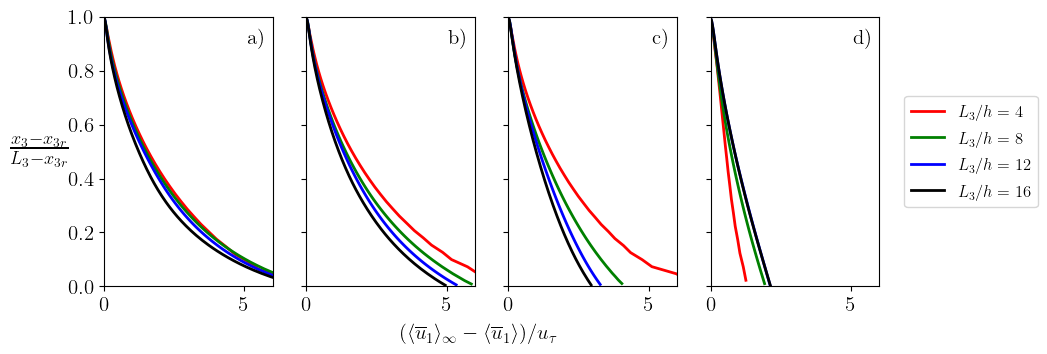

In [10]:
# import cubehelix
from matplotlib import rc
# import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)
pattern = re.compile(r'\d+')
fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
namelist = ['a)', 'b)', 'c)', 'd)']
clist = ['r', 'g', 'b', 'k']
pack_list = ["500", "250", "167", "83"]
for index, pack_den in enumerate(pack_list):
    plot_firstorder_outer_defect(pack_den, axs[index], clist, namelist, index)
    # fig1.text(0.1, 0.05, r'\textbf{%s}' % namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15) # This if you want a,b,c to be bold
    fig1.text(0.9, 0.9, r'%s' % namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 1)
    axs[index].set_xlim(0, 6)
    # axs[index].plot(np.linspace(0, 7, 20), np.ones(20), color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
# axs[3].set_xlim(0, 4)
fig1.text(0.5, -0.025, r'$(\langle \overline{u}_{1}\rangle_{\infty} - \langle\overline{u}_1\rangle)/u_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.06, 0.5, r'$\frac{x_3-x_{3r}}{L_3-x_{3r}}$', ha='center', va='center', rotation='horizontal', fontsize=19)
# fig1.savefig('eps_figs/vel_defect_domhimpact_limupdated.pdf', format='pdf', bbox_inches="tight")

### Computing 2nd order statistics

In [11]:
var_list = ['uu', 'uw']
temp = {}

h5_files += ['chan_hxsx83e-3_8x36x48.h5', 'chan_hxsx83e-3_4x18x24.h5']

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        temp["%s%s" % (v, sim)] = f["%s%s" % (v, sim)].mean(dim = ['x', 'y']) - (f["%s%s" % (v[0], sim)] * f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y'])

disp = {}

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        disp["%s%s" % (v, sim)] = (f["%s%s" % (v[0], sim)]*f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y']) - f["%s%s" % (v[0], sim)].mean(dim = ['x', 'y']) * f["%s%s" % (v[1], sim)].mean(dim = ['x', 'y'])

stress = {}

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        stress["%s%s" % (v, sim)] = temp["%s%s" % (v, sim)] + disp["%s%s" % (v, sim)]

In [12]:
# To load the ww stress
field_list = ['w', 'ww']
g = {} # Loads all the variables
#h5_files = ['chan_l4_8x24x48.h5']
h5_files = os.listdir('/home/as2204/TACC_postprocess/high_reso_w')
h5_files = [match for match in h5_files if "ruw" not in match]
filepath = '/home/as2204/TACC_postprocess/high_reso_w'

for sim in h5_files:
    # print(sim)
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        g['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

var_list = ['ww']
# temp = {}

# h5_files += ['chan_hxsx83e-3_8x36x48.h5', 'chan_hxsx83e-3_4x18x24.h5']

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        temp["%s%s" % (v, sim)] = g["%s%s" % (v, sim)].mean(dim = ['x', 'y']) - (g["%s%s" % (v[0], sim)] * g["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y'])

# disp = {}

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        disp["%s%s" % (v, sim)] = (g["%s%s" % (v[0], sim)]*g["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y']) - g["%s%s" % (v[0], sim)].mean(dim = ['x', 'y']) * g["%s%s" % (v[1], sim)].mean(dim = ['x', 'y'])

# stress = {}

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        stress["%s%s" % (v, sim)] = temp["%s%s" % (v, sim)] + disp["%s%s" % (v, sim)]


In [13]:
h5_files = ['chan_hxsx83e-3_8x36x48.h5', 'chan_hxsx83e-3_4x18x24.h5']
filepath = '/home/as2204/TACC_postprocess/high_reso_new_stl_averages'

for sim in h5_files:
    # print(sim)
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        g['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        temp["%s%s" % (v, sim)] = g["%s%s" % (v, sim)].mean(dim = ['x', 'y']) - (g["%s%s" % (v[0], sim)] * g["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y'])

# disp = {}

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        disp["%s%s" % (v, sim)] = (g["%s%s" % (v[0], sim)]*g["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y']) - g["%s%s" % (v[0], sim)].mean(dim = ['x', 'y']) * g["%s%s" % (v[1], sim)].mean(dim = ['x', 'y'])

# stress = {}

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        stress["%s%s" % (v, sim)] = temp["%s%s" % (v, sim)] + disp["%s%s" % (v, sim)]

### Figure 10

Text(0.07, 0.5, '$x_3/h$')

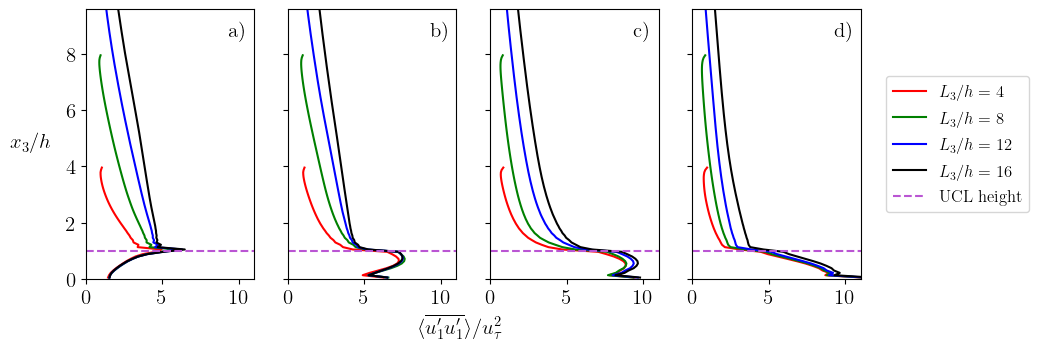

In [14]:
def output_d_kanda2_l(pack_den):
    "highest values"
    if pack_den == "l2":
        return 0.77
    if pack_den == "l4":
        return 0.4
    if pack_den == "l6":
        return 0.06
    if pack_den == "l12":
        return 0
    
def plot_secondorder_hscaling(pack_den, ax1, clist, namelist, index, var="uu"):

    key_list = [f'uu_{pack_den}_4x12x24', f'uu_{pack_den}_8x24x48', f'uu_{pack_den}_12x36x72', f'uu_{pack_den}_16x48x96']
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[1])
        
        ax1.plot(stress["%s" % key], stress["%s" % key]['z'], clist[index1], linewidth=1.5, label=r'$L_3/h = %d$' % int(delta))
    # ax1.legend()
    ax1.set_xlim(0, 11)
    ax1.set_ylim(0, 16)
    ax1.set_xticks([0, 5, 10])
    ax1.plot(np.linspace(0, 16, 20), np.ones(20), color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
    if index==3:
        ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)

import cubehelix
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)
pattern = re.compile(r'\d+')
fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
namelist = ['a)', 'b)', 'c)', 'd)']
clist = ['r', 'g', 'b', 'k']
pack_list = ["l2", "l4", "l6", "l12"]
for index, pack_den in enumerate(pack_list):
    plot_secondorder_hscaling(pack_den, axs[index], clist, namelist, index)
    fig1.text(0.9, 0.9, r'%s' % namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 9.6)
    # axs[2].set_xlim(0.5, 4)
fig1.text(0.5, -0.025, r'$\langle\overline{u_1^\prime u_1^\prime}\rangle/u^2_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.07, 0.5, r'$x_3/h$', ha='center', va='center', rotation='horizontal', fontsize=15)
# plt.savefig('eps_figs/var_hscale_domhimpact_limupdated.pdf', format='pdf', bbox_inches="tight")

### Figure 12

In [16]:
def plot_secondorder_outerscaling2(pack_den, ax1, clist, namelist, index, var="uu"):

    key_list = [f'uu_hxsx{pack_den}e-3_4x12x24', f'uu_hxsx{pack_den}e-3_8x24x48', f'uu_hxsx{pack_den}e-3_12x36x72', f'uu_hxsx{pack_den}e-3_16x48x96']

    if pack_den == '83':
        key_list = [f'uu_hxsx{pack_den}e-3_4x18x24', f'uu_hxsx{pack_den}e-3_8x36x48', f'uu_hxsx{pack_den}e-3_12x36x72', f'uu_hxsx{pack_den}e-3_16x48x96']
    print(key_list)
    # key_list = key_list[2:] + key_list[:2]
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[2])
        d = output_d_kanda2(pack_den)
        rsl_height = float(1000/int(pack_den)/16) * delta / 2 + d
        rsl_node = round(rsl_height * 12)

        if pack_den == '83' and '_8x' in key:
            rsl_node = round(rsl_height * 8)

        if pack_den == '83' and '_4x' in key:
            rsl_node = round(rsl_height * 8)
        
        ax1.plot(stress["%s" % key][rsl_node:], (stress["%s" % key]['z'][rsl_node:] - rsl_height) / (delta - rsl_height), clist[index1], linewidth=2, label=r'$L_3/h = %d$' % int(delta))
        
    if index==3:
        ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)

['uu_hxsx500e-3_4x12x24', 'uu_hxsx500e-3_8x24x48', 'uu_hxsx500e-3_12x36x72', 'uu_hxsx500e-3_16x48x96']
['uu_hxsx250e-3_4x12x24', 'uu_hxsx250e-3_8x24x48', 'uu_hxsx250e-3_12x36x72', 'uu_hxsx250e-3_16x48x96']
['uu_hxsx167e-3_4x12x24', 'uu_hxsx167e-3_8x24x48', 'uu_hxsx167e-3_12x36x72', 'uu_hxsx167e-3_16x48x96']
['uu_hxsx83e-3_4x18x24', 'uu_hxsx83e-3_8x36x48', 'uu_hxsx83e-3_12x36x72', 'uu_hxsx83e-3_16x48x96']


Text(0.06, 0.5, '$\\frac{x_3-x_{3r}}{L_3-x_{3r}}$')

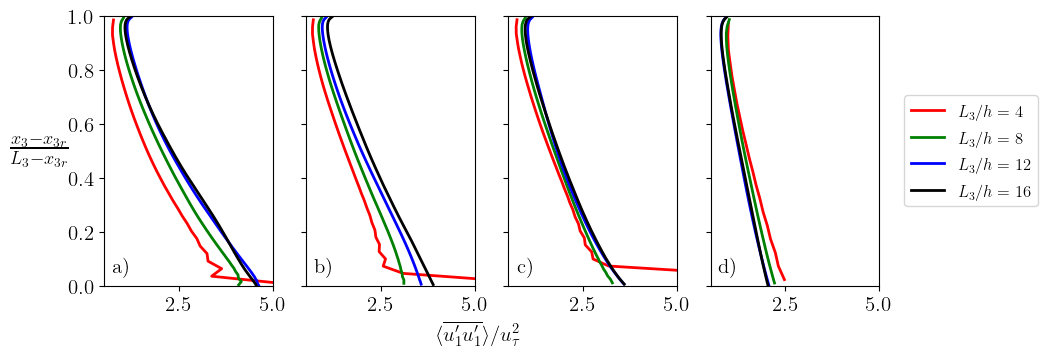

In [17]:
import cubehelix
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)
pattern = re.compile(r'\d+')
fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
namelist = ['a)', 'b)', 'c)', 'd)']
clist = ['r', 'g', 'b', 'k']
pack_list = ["500", "250", "167", "83"]
for index, pack_den in enumerate(pack_list):
    plot_secondorder_outerscaling2(pack_den, axs[index], clist, namelist, index)
    fig1.text(0.1, 0.05, r'%s' % namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 1)
    axs[index].set_xlim(0.5, 5)
fig1.text(0.5, -0.025, r'$\langle\overline{u_1^\prime u_1^\prime}\rangle/u^2_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.06, 0.5, r'$\frac{x_3-x_{3r}}{L_3-x_{3r}}$', ha='center', va='center', rotation='horizontal', fontsize=19)
# plt.savefig('eps_figs/var_defect_domhimpact_limupdated.pdf', format='pdf', bbox_inches="tight")